# SALARY PREDICTION FROM EMAIL NETWORK

**Note: networxk package version 1.11**

## INTRODUCTION

In this data science project I combine **network analysis** and **supervised machine learning** to predict given an email network of a company, which employees are receiving a management position salary.

The email network of the company is defined as follows:
* Each node corresponds to a person at the company.
* Each edge indicates that at least one email has been sent between two people.
* The network contains the node attributes *Department* and *ManagementSalary*.
* *Department* indicates the department in the company which the person belongs to, and *ManagementSalary* indicates whether that person is receiving a management position salary (1) or if not (0).

The problem we face is that there are missing values for the attribute *ManagementSalary*. **Our goal will be to predict these values as the probability that the corresponding employee is receiving a management position salary.**

The steps we are going to follow are:

1. Extract the data from the network.
2. Design a strategy to use the information of the network to predict the target value.
3. Clean de data.
4. Feature selection.
5. Train and test different classifiers.
6. Choose the best classifier.
7. Reach a conclusion.

## 1. EXTRACTING INFORMATION FROM THE NETWORK

In this section, we are going to analyse the network to know more about the company.

We have in a text file all the necessary information about the email network, using NetworkX we will transform the data in a graph object. NetworkX is a popular Python library for studying graphs and networks. 

To explore the data, we can ask ourselves some questions:

- How many employees at the company are using the email?
- How many employees at the company have been in contact through email?

In [1]:
import networkx as nx
file = 'email_prediction.txt'
G = nx.read_gpickle(file)
print('{} employees are using the email and {} employees have been in contact.'.format(len(G.nodes()),len(G.edges())))

1005 employees are using the email and 16706 employees have been in contact.


If we look at the attributes of the network, we can see how there are people with missing values for the node attribute *Management Salary*:

In [2]:
G.nodes(data = True)[:10]

[(0, {'Department': 1, 'ManagementSalary': 0.0}),
 (1, {'Department': 1, 'ManagementSalary': nan}),
 (2, {'Department': 21, 'ManagementSalary': nan}),
 (3, {'Department': 21, 'ManagementSalary': 1.0}),
 (4, {'Department': 21, 'ManagementSalary': 1.0}),
 (5, {'Department': 25, 'ManagementSalary': nan}),
 (6, {'Department': 25, 'ManagementSalary': 1.0}),
 (7, {'Department': 14, 'ManagementSalary': 0.0}),
 (8, {'Department': 14, 'ManagementSalary': nan}),
 (9, {'Department': 14, 'ManagementSalary': 0.0})]

We store the attributes in a data frame, where each column is a feature and the index is the number of the employee:

In [3]:
import pandas as pd
df = pd.DataFrame(index = G.nodes())
df['department'] = pd.Series(nx.get_node_attributes(G,'Department'))
df['management_salary'] = pd.Series(nx.get_node_attributes(G, 'ManagementSalary'))
df.head()

,department,management_salary
0,1,0.0
1,1,NaN
2,21,NaN
3,21,1.0
4,21,1.0


We can now answer more questions:

* How many departments does the company have?
* Which is the department with the most employees?

In [4]:
print('The company has {} departments and the department with most employees is number {} with {} employees.'
      .format(df['department'].nunique(), df['department'].value_counts().idxmax(), df['department'].value_counts().iloc[0]))

The company has 42 departments and the department with most employees is number 4 with 109 employees.


## 2. STRATEGY

Once we already know more about the company, we can focus on the goal of predict which employees are receiving a management position salary. In order to achieve it we will make the following realistic assumption:

**'*An employee with a management position salary is going to be somebody whose 'importance' in the network is higher than somebody who doesn't have that management position salary.*'**

At this point, there are different ways to evaluate the importance of a node in a network, we will take into consideration the following ones with their definitions:

* **Degree**. Important nodes have many connections.
* **Closeness**. Important nodes are close to other nodes.
* **Betweenness**. Important node connect other nodes. 
* **Page Rank**. Important nodes are those with many in-links from important pages (developed by Google founders).
* **Clustering**. Important nodes have a higher fraction of pairs of the node's friends that are friends with each other.

We compute these values for all the employees (nodes) of the network:

In [5]:
df['degree'] = pd.Series(nx.degree_centrality(G))
df['closeness'] = pd.Series(nx.closeness_centrality(G, normalized = True))
df['betweenness'] = pd.Series(nx.betweenness_centrality(G, normalized = True, endpoints = False))
df['page_rank'] = pd.Series(nx.pagerank(G, alpha = 0.8))
df['clustering'] = pd.Series(nx.clustering(G))

We see in the data frame the new features for each employee:

In [6]:
df.head()

,department,management_salary,degree,closeness,betweenness,page_rank,clustering
0,1,0.0,0.043825,0.421991,0.001124,0.001202,0.276423
1,1,NaN,0.051793,0.422360,0.001195,0.001395,0.265306
2,21,NaN,0.094622,0.461490,0.006570,0.002531,0.297803
3,21,1.0,0.070717,0.441663,0.001654,0.001759,0.384910
4,21,1.0,0.095618,0.462152,0.005547,0.002424,0.318691


## 3. CLEANING THE DATA

In this section, we are going to divide the employees that we already know are receiving a management position salary from those who we do not know yet.

In **df_data** we store the data we are going to use to train and test the model and in **df_predict** we store the employees we have to predict their attribute *ManagementSalary*. (We can see how the column *management_salary* in df_predict have NaN).

In [7]:
import numpy as np
df_data = df[~ np.isnan(df.management_salary)]
df_predict = df[np.isnan(df.management_salary)]
df_data.head()

,department,management_salary,degree,closeness,betweenness,page_rank,clustering
0,1,0.0,0.043825,0.421991,0.001124,0.001202,0.276423
3,21,1.0,0.070717,0.441663,0.001654,0.001759,0.384910
4,21,1.0,0.095618,0.462152,0.005547,0.002424,0.318691
6,25,1.0,0.114542,0.475805,0.012387,0.003045,0.155183
7,14,0.0,0.071713,0.420156,0.002818,0.001948,0.287785


In [8]:
df_predict.head()

,department,management_salary,degree,closeness,betweenness,page_rank,clustering
1,1,NaN,0.051793,0.422360,0.001195,0.001395,0.265306
2,21,NaN,0.094622,0.461490,0.006570,0.002531,0.297803
5,25,NaN,0.170319,0.501484,0.030995,0.004802,0.107002
8,14,NaN,0.036853,0.413151,0.000557,0.001048,0.447059
14,4,NaN,0.079681,0.442068,0.003726,0.002091,0.215784


We divide df_data in **X (features)** and **y (target value)** and drop the attribute management_salary from df_predict because is giving no information and is the value we want to predict:

In [9]:
X = df_data.drop(columns = ['management_salary']) # features of each data instance
y = df_data.management_salary # target value for each data instance (sample)
X_predict = df_predict.drop(columns = ['management_salary'])

## 4. FEATURE SELECTION

To do feature selection, we are going to plot a scatter matrix where points represent the target values. The yellow ones represent employees who are receiving a management position salary and black ones those who do not.

**The features we are going to use are the ones that divide better the target value in two different groups. To see this, we only have to focus on the axis of the feature and see if on the direction of the axis the points are divided.**

How we can see on the scatter matrix there are some features that do a better task when talking about separating the target value, for instance, **degree, closeness, betweenness and page_rank**. Whereas *department*, how its obvious do no separate the target value (it is not easy to predict if an employee is receiving a management position salary by knowing only the department where one works). Neither *clustering* is a good feature for our goal. In those features, we can see how the yellow and black points are mixed all together.

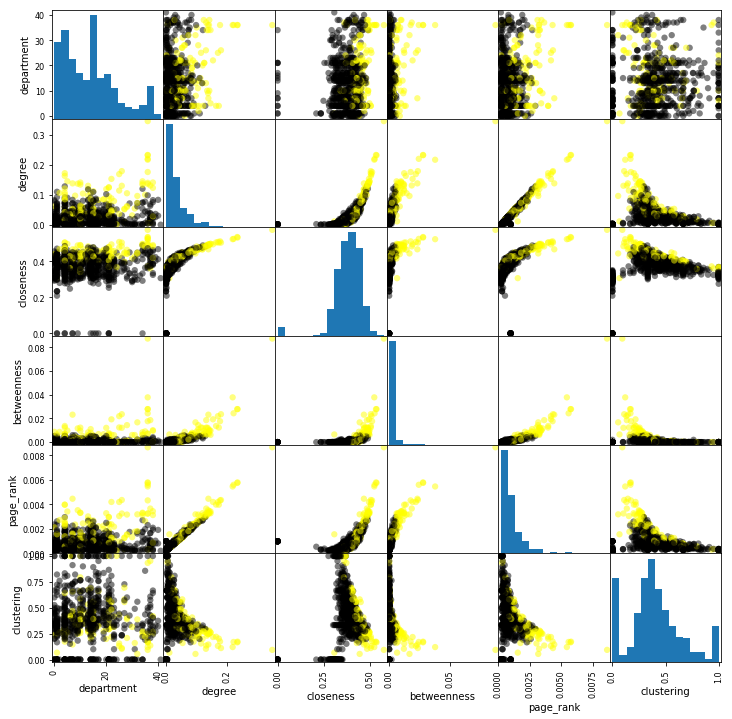

In [10]:
from matplotlib import cm
%matplotlib inline
cmap = cm.get_cmap('gnuplot')
scatter = pd.plotting.scatter_matrix(X, c= y, marker = 'o', s=40, hist_kwds={'bins':15},
                                     figsize=(12,12), cmap=cmap)

We can drop the features that are not giving information about the target value:

In [11]:
X = X.drop(columns = ['department','clustering'])
X_predict = X_predict.drop(columns = ['department','clustering'])

## 5. TRAINING AND TESTING DIFFERENT ESTIMATORS

In this section, we will train different estimators. In order to see how the performance of the classifiers increase when we adjust each  model specifically we are going to follow the next steps and compute the score after each one:

1. Test the classifier with the default parameters.
2. Preprocess the data if the classifier needed it.
3. Tune the parameters.

To test the classifiers we will use the **ROC_AUC** score that can be interpreted as the probability that the classifier will assign a higher score to a randomly chosen positive example than to a randomly chosen negative example.



In [12]:
# initializing a list to store the scores of the different classifiers
l_score =[]

### KNeighbors Classifier

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)


# Default parameters
knn = KNeighborsClassifier()
score_knn = cross_val_score(knn, X, y, cv = 10, scoring= 'roc_auc').mean()
print('Default parameters, ROC_AUC score: {}'.format(score_knn))

# With preprocessing
knn_2 = KNeighborsClassifier()
knn_2_pipe = make_pipeline(StandardScaler(), knn_2)
score_knn_2 = cross_val_score(knn_2_pipe, X, y, cv = 10, scoring= 'roc_auc').mean()
print('With preprocessing, ROC_AUC score: {}'.format(score_knn_2))

# Tuning parameters (with preprocessing)
knn_3 = KNeighborsClassifier()
pipe = Pipeline([('scale',StandardScaler()),('clf',knn_3)])
k_range = range(1,51)
weight_options = ['uniform','distance']
param_grid = dict(clf__n_neighbors = k_range, clf__weights = weight_options)
grid_1 = GridSearchCV(pipe, param_grid = param_grid, cv = 10, scoring = 'roc_auc')
grid_1.fit(X,y)
l_score.append(grid_1.best_score_)
print('Tuning parameters (with preprocessing), ROC_AUC score: {}'.format(grid_1.best_score_))
print('Best parameters {}'.format(grid_1.best_params_))


Default parameters, ROC_AUC score: 0.829642781986532
With preprocessing, ROC_AUC score: 0.8560818377224628
Tuning parameters (with preprocessing), ROC_AUC score: 0.9331720586389413
Best parameters {'clf__weights': 'uniform', 'clf__n_neighbors': 47}


### Logistic Regression

In [14]:
from sklearn.linear_model import LogisticRegression

# Default parameters
logreg = LogisticRegression() 
score_logreg = cross_val_score(logreg, X, y, cv = 10, scoring= 'roc_auc').mean()
print('Default parameters, ROC_AUC score: {}'.format(score_logreg))

# With preprocessing
logreg_2 = LogisticRegression()
logreg_2_pipe = make_pipeline(StandardScaler(), logreg_2)
score_logreg_2 = cross_val_score(logreg_2_pipe, X, y, cv = 10, scoring= 'roc_auc').mean()
print('With preprocessing, ROC_AUC score: {}'.format(score_logreg_2))

# Tuning parameters (with preprocessing)
logreg_3 = LogisticRegression()
pipe = Pipeline([('scale',StandardScaler()),('clf',logreg_3)])
C_range = [0.01, 0.1, 1, 10]
param_grid = dict(clf__C = C_range, )
grid = GridSearchCV(pipe, param_grid = param_grid, cv = 10, scoring = 'roc_auc')
grid.fit(X,y)
print('Tuning parameters (with preprocessing), ROC_AUC score: {}'.format(grid.best_score_))
print('Best parameter {}'.format(grid.best_params_))


# Tuning parameters (without preprocessing)
logreg_4 = LogisticRegression()
C_range = [0.01, 0.1, 1, 10]
param_grid = dict(C = C_range, )
grid_2 = GridSearchCV(logreg_4, param_grid = param_grid, cv = 10, scoring = 'roc_auc')
grid_2.fit(X,y)
l_score.append(grid_2.best_score_)
print('Tuning parameters (without preprocessing), ROC_AUC score: {}'.format(grid_2.best_score_))
print('Best parameter {}'.format(grid_2.best_params_))



Default parameters, ROC_AUC score: 0.923297897126022
With preprocessing, ROC_AUC score: 0.9183494167869167
Tuning parameters (with preprocessing), ROC_AUC score: 0.9181598521737965
Best parameter {'clf__C': 1}
Tuning parameters (without preprocessing), ROC_AUC score: 0.9236332388100317
Best parameter {'C': 10}


### Linear Support Vector Classification

In [15]:
from sklearn.svm import LinearSVC

# Default parameters
lsvc = LinearSVC() 
score_lsvc = cross_val_score(lsvc, X, y, cv = 10, scoring= 'roc_auc').mean()
print('Default parameters, ROC_AUC score: {}'.format(score_lsvc))

# With preprocessing
lsvc_2 = LinearSVC()
lsvc_2_pipe = make_pipeline(StandardScaler(), lsvc_2)
score_lsvc_2 = cross_val_score(lsvc_2_pipe, X, y, cv = 10, scoring= 'roc_auc').mean()
print('With preprocessing, ROC_AUC score: {}'.format(score_lsvc_2))

# Tuning parameters (without preprocessing)
lsvc_3 = LinearSVC()
C_range = [0.01, 0.1, 1, 10]
param_grid = dict(C = C_range, )
grid_3 = GridSearchCV(lsvc_3, param_grid = param_grid, cv = 10, scoring = 'roc_auc')
grid_3.fit(X,y)
l_score.append(grid_3.best_score_)
print('Tuning parameters (without preprocessing), ROC_AUC score: {}'.format(grid_3.best_score_))
print('Best parameter {}'.format(grid_3.best_params_))


Default parameters, ROC_AUC score: 0.9218889039201539
With preprocessing, ROC_AUC score: 0.9083553165584416
Tuning parameters (without preprocessing), ROC_AUC score: 0.9226824663826656
Best parameter {'C': 0.1}


### Support Vector Classification

In [16]:
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler


# Default parameters
svcc = SVC()
score_svcc = cross_val_score(svcc, X, y, cv = 10, scoring= 'roc_auc').mean()
print('Default parameters, ROC_AUC score: {}'.format(score_svcc))

# With preprocessing
svcc_2 = SVC()
svcc_2_pipe = make_pipeline(MinMaxScaler(), svcc_2)
score_svcc_2 = cross_val_score(svcc_2_pipe, X, y, cv = 10, scoring= 'roc_auc').mean()
print('With preprocessing, ROC_AUC score: {}'.format(score_svcc_2))

# Tuning parameters (without preprocessing)
svcc_3 = SVC()
C_range = [0.01, 0.1, 1, 10]
param_grid = dict(C = C_range, )
grid_4 = GridSearchCV(svcc_3, param_grid = param_grid, cv = 10, scoring = 'roc_auc')
grid_4.fit(X,y)
l_score.append(grid_4.best_score_)
print('Tuning parameters (without preprocessing), ROC_AUC score: {}'.format(grid_4.best_score_))
print('Best parameter {}'.format(grid_4.best_params_))



Default parameters, ROC_AUC score: 0.9190634018759019
With preprocessing, ROC_AUC score: 0.9018116432178932
Tuning parameters (without preprocessing), ROC_AUC score: 0.9191570658204125
Best parameter {'C': 0.01}


### Random Forest

In [17]:
from sklearn.ensemble import RandomForestClassifier

# Default parameters
rfc = RandomForestClassifier()
score_rfc = cross_val_score(rfc, X, y, cv = 10, scoring= 'roc_auc').mean()
print('Default parameters, ROC_AUC score: {}'.format(score_rfc))

# Tuning parameters (without preprocessing)
rfc_2 = RandomForestClassifier()
n_range = range(10,101,10)
param_grid = dict(n_estimators = n_range)
grid_5 = GridSearchCV(rfc_2, param_grid = param_grid, cv = 10, scoring = 'roc_auc')
grid_5.fit(X,y)
l_score.append(grid_5.best_score_)
print('Tuning parameters (without preprocessing), ROC_AUC score: {}'.format(grid_5.best_score_))
print('Best parameter {}'.format(grid_5.best_params_))



Default parameters, ROC_AUC score: 0.8808301579785954
Tuning parameters (without preprocessing), ROC_AUC score: 0.9101009681811475
Best parameter {'n_estimators': 70}


### Gradient Boosted Decision Trees

In [18]:
from sklearn.ensemble import GradientBoostingClassifier

# Default parameters
gbc = GradientBoostingClassifier()
score_gbc = cross_val_score(gbc, X, y, cv = 10, scoring= 'roc_auc').mean()
print('Default parameters, ROC_AUC score: {}'.format(score_rfc))

# Tuning parameters (without preprocessing)
gbc_2 = RandomForestClassifier()
n_range = range(10,101,10)
param_grid = dict(n_estimators = n_range)
grid_6 = GridSearchCV(gbc_2, param_grid = param_grid, cv = 10, scoring = 'roc_auc')
grid_6.fit(X,y)
l_score.append(grid_6.best_score_)
print('Tuning parameters (without preprocessing), ROC_AUC score: {}'.format(grid_6.best_score_))
print('Best parameter {}'.format(grid_6.best_params_))

Default parameters, ROC_AUC score: 0.8808301579785954
Tuning parameters (without preprocessing), ROC_AUC score: 0.9145100095050297
Best parameter {'n_estimators': 90}


## 6. CHOOSING THE BEST ESTIMATOR

We have tested all the classifiers and we know the score for each of them. Clearly, the best performance has been obtained tuning the parameters with a GridSearchCV. Now for each classifier, we are going to compute the execution time to add it as a new criterion when choosing the best estimator.

In [19]:
import time

grids = [grid_1, grid_2, grid_3, grid_4, grid_5, grid_6]
l_time = []
for estimator in grids:
    est_t = []
    for rep in range(10): # we do 10 simulations for each estimator
        start = time.time()
        estimator.predict(X_predict) 
        end = time.time()
        est_t.append(end-start)  
    l_time.append(np.asarray(est_t).mean())

We store the scores and execution times in a data frame:

In [20]:
l_estim = ['KNeighbours','Logit', 'LSVC','SVC','Random Forest','GB']
df_est = pd.DataFrame({'Estimator': l_estim, 'Score': l_score, 'Execution time [s]': l_time})
df_est

,Estimator,Execution time [s],Score
0,KNeighbours,0.003375,0.933172
1,Logit,0.000360,0.923633
2,LSVC,0.000420,0.922682
3,SVC,0.001293,0.919157
4,Random Forest,0.006255,0.910101
5,GB,0.007215,0.914510


To see graphically the performance of each classifier, we will do a scatter plot. In the x-axis we have the score and in the y-axis we have the execution time:

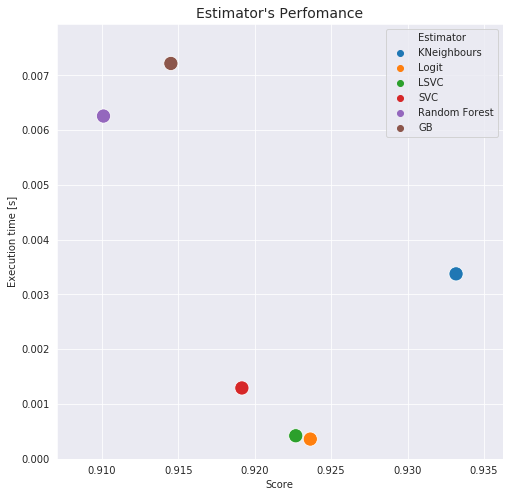

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
plt.figure(figsize=(8,8))
g = sns.scatterplot(data = df_est, y = 'Execution time [s]', x = 'Score', s = 200, hue = 'Estimator')
plt.ylim(0, df_est['Execution time [s]'].max() *1.1)
plt.title("Estimator's Perfomance", fontsize = 14)
plt.show()

From the scatter plot we can see how the highest score is got from the KNeighbours Classifier and the lowest from the Random Forest. In terms of execution time, we can differentiate two groups, the one composed by the the Gradient Boosted Decision Trees and the Random Forest and the other composed by the SVC, the LSVC and the Logistic Regression, this last group is much faster converging to the solution.

## 7. CONCLUSION

Under the assumption that for our task the time is not a limiting resource, we choose as the best classifier the **KNeighbours Classifier**. We have achieved to create an algorithm that predicts if a employee has a management job postion in a company from the email network of that company.

Finally, we proceed to compute the probabilities of the classifier giving a positive value to the target. With this information we can set a threshold to increase the sensitivity of our classifier and be more confident with the final conclusion. We set the threshold in the 80%:

In [22]:
X_predict['Probability'] = grid_1.predict_proba(X_predict)[:,1]
prob = X_predict.index[X_predict['Probability'] > 0.8].tolist()
print('Employees {} are receiving a management position salary with a higher probability of 80%.'.
      format(prob))

Employees [5, 62, 65, 142, 249, 283, 420, 434, 533, 820] are receiving a management position salary with a higher probability of 80%.
